# 0.3 accident geographic evaluation

- This notebook contains the evaluation of the accidents base on their geographic zone while analysing the influence of slopes, crossroads, traffic lights, elevation and traffic.

# Import packages

In [110]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geoplot as gplt
import geojson
import h3
import folium
from folium import Map, Marker, GeoJson
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import branca.colormap as cm
from geojson.feature import *
import json
import ast
from scipy import stats

## Functions

The following functions were adapted from the Uber github: https://github.com/uber/h3-py-notebooks/blob/master/notebooks/urban_analytics.ipynb

In [111]:
def counts_by_hexagon(df, resolution):
    """
    Use h3.geo_to_h3 to index each data point into the spatial index of the specified resolution.
    Use h3.h3_to_geo_boundary to obtain the geometries of these hexagons
    
    Ex counts_by_hexagon(data, 9)
    """
    df = df[["latitude","longitude"]]
    
    df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["latitude"], row["longitude"], resolution), axis = 1)
    
    df_aggreg = df.groupby(by = "hex_id").size().reset_index()
    df_aggreg.columns = ["hex_id", "value"]
    
    df_aggreg["geometry"] =  df_aggreg.hex_id.apply(lambda x: {"type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(x,geo_json=True)]})
    
    return df_aggreg




def hexagons_dataframe_to_geojson(df_hex, file_output = None):
    """
    Produce the GeoJSON for a dataframe that has a geometry column in geojson 
    format already, along with the columns hex_id and value
    
    Ex counts_by_hexagon(data)
    """    
    list_features = []
    
    for i,row in df_hex.iterrows():
        feature = Feature(geometry = row["geometry"] , id=row["hex_id"], properties = {"value" : row["value"]})
        list_features.append(feature)
        
    feat_collection = FeatureCollection(list_features)
    
    geojson_result = json.dumps(feat_collection)
    
    #optionally write to file
    if file_output is not None:
        with open(file_output,"w") as f:
            json.dump(feat_collection,f)
    
    return geojson_result




def choropleth_map(df_aggreg, border_color = 'black', fill_opacity = 0.4, initial_map = None, with_legend = False,
                   kind = "linear"):
    
    """
    Creates choropleth maps given the aggregated data.
    """    
    #colormap
    min_value = df_aggreg["value"].min()
    max_value = df_aggreg["value"].max()
    m = round ((min_value + max_value ) / 2 , 0)
    
    #take resolution from the first row
    res = h3.h3_get_resolution(df_aggreg.loc[0,'hex_id'])
    
    if initial_map is None:
        initial_map = Map(location= [38.76, -9.17], zoom_start=12, tiles="cartodbpositron", 
                attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )
        

    #the colormap 
    #color names accepted https://github.com/python-visualization/branca/blob/master/branca/_cnames.json
    if kind == "linear":
        custom_cm = cm.LinearColormap(['green','yellow','red'], vmin=min_value, vmax=max_value)
    elif kind == "outlier":
        #for outliers, values would be -11,0,1
        custom_cm = cm.LinearColormap(['blue','white','red'], vmin=min_value, vmax=max_value)
    elif kind == "filled_nulls":
        custom_cm = cm.LinearColormap(['sienna','green','yellow','red'], 
                                      index=[0,min_value,m,max_value],vmin=min_value,vmax=max_value)
   

    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df_hex = df_aggreg)
    
    #plot on map
    name_layer = "Choropleth " + str(res)
    if kind != "linear":
        name_layer = name_layer + kind
        
    GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': custom_cm(feature['properties']['value']),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity 
        }, 
        name = name_layer
    ).add_to(initial_map)
    #add legend (not recommended if multiple layers)
    if with_legend == True:
        custom_cm.add_to(initial_map)
    
    
    
    return initial_map

# 1. Accidents geographic visualization

After some experimentation with the resolution value we settled for resolution of 8 for giving the best compromise between detail and generalization.

In [112]:
resolution=8

Read file, remove accidents outside Lisbon and convert to hex ids.

In [161]:
accidentes_w_geo_path = '../00-data/processed/data_w_geolocation.parquet'
accidentes_w_geo = pd.read_parquet(accidentes_w_geo_path, engine='pyarrow')
accidentes_w_geo=accidentes_w_geo[(accidentes_w_geo['latitude']>38.6) & (accidentes_w_geo['latitude']<38.8) & (accidentes_w_geo['longitude']>-9.4) & (accidentes_w_geo['longitude']<-8.98)]
accidentes_w_geo

,data,latitude,longitude,tipo acidente
0,2019-01-02 09:50:00,38.720912,-9.130242,Colisão/Despiste
1,2019-01-02 12:25:00,38.738775,-9.157884,Colisão/Despiste
2,2019-01-02 13:05:00,38.728779,-9.147518,Colisão/Despiste
3,2019-01-02 15:10:00,38.768367,-9.172899,Atropelamento
4,2019-01-02 15:30:00,38.705791,-9.205268,Atropelamento
...,...,...,...,...
1792,2019-12-30 13:24:00,38.754903,-9.171398,Colisão/Despiste
1793,2019-12-30 16:44:00,38.728911,-9.161190,Colisão/Despiste
1794,2019-12-30 19:51:00,38.710238,-9.153392,Colisão/Despiste
1795,2019-12-31 15:19:00,38.748713,-9.118734,Colisão/Despiste


Aggregates accidents by zone

In [162]:
df_aggreg = counts_by_hexagon(accidentes_w_geo, resolution)
df_aggreg.sort_values(by = "value", ascending = False, inplace = True)

C:\Users\duartgo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [163]:
df_aggreg

,hex_id,value,geometry
40,88393362bbfffff,111,"{'type': 'Polygon', 'coordinates': [((-9.14852..."
19,8839336287fffff,103,"{'type': 'Polygon', 'coordinates': [((-9.17049..."
22,8839336291fffff,99,"{'type': 'Polygon', 'coordinates': [((-9.14710..."
78,8839336765fffff,82,"{'type': 'Polygon', 'coordinates': [((-9.13276..."
23,8839336293fffff,78,"{'type': 'Polygon', 'coordinates': [((-9.13612..."
...,...,...,...
83,8839337527fffff,2,"{'type': 'Polygon', 'coordinates': [((-9.21162..."
84,8839337531fffff,1,"{'type': 'Polygon', 'coordinates': [((-9.18822..."
14,8839336219fffff,1,"{'type': 'Polygon', 'coordinates': [((-9.22881..."
13,88393360e9fffff,1,"{'type': 'Polygon', 'coordinates': [((-9.17472..."


Map creation

In [115]:
hexmap = choropleth_map(df_aggreg = df_aggreg, with_legend = True)
hexmap

Sames steps reproduced for the 2 type of accidents

In [116]:
accidentes_w_geo_CD=accidentes_w_geo[accidentes_w_geo['tipo acidente']=='Colisão/Despiste']
accidentes_w_geo_A=accidentes_w_geo[accidentes_w_geo['tipo acidente']=='Atropelamento']

In [117]:
df_aggreg_CD = counts_by_hexagon(accidentes_w_geo_CD, resolution)
df_aggreg_CD.sort_values(by = "value", ascending = False, inplace = True)

df_aggreg_A = counts_by_hexagon(accidentes_w_geo_A, resolution)
df_aggreg_A.sort_values(by = "value", ascending = False, inplace = True)

C:\Users\duartgo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [118]:
hexmap = choropleth_map(df_aggreg = df_aggreg_CD, with_legend = True)
hexmap

In [119]:
hexmap = choropleth_map(df_aggreg = df_aggreg_A, with_legend = True)
hexmap

It is possible to see that run overs happen more frequently in downtown which is expected considering the older streets and higher contact drivers have with people

## 2. Analysis of the geo features files

Read different files

In [11]:
path_altimetria = '../00-data/raw/ALTIMETRIA.shp'
path_cruzamentos = '../00-data/raw/Cruzamentos_SLAT.shp'
path_declives = '../00-data/raw/Mob_declives.shp'
path_semaforos = '../00-data/raw/Localização_semaforos.shp'

# 2.1. Elevation

Change data reference using crs

In [12]:
altimetria = gpd.read_file(path_altimetria)
altimetria_oldCRS=altimetria.crs
altimetria = altimetria.to_crs("EPSG:4326")
altimetria.T

,0,1,2,3,4,5,6,7,8,9,...,218783,218784,218785,218786,218787,218788,218789,218790,218791,218792
OBJECTID,28,29,30,31,32,33,34,35,36,37,...,211988,211989,211990,211991,212214,212215,212216,212217,212218,212219
LAYER,5103,5103,5103,5103,5103,5101,5103,5103,5103,5103,...,5101,5103,5101,5101,5101,5101,5101,5101,5101,5101
ELEVATION,109.0,109.0,103.0,103.0,103.0,95.0,103.0,96.0,102.0,97.0,...,50.0,51.0,55.0,55.0,60.0,60.0,55.0,65.0,65.0,70.0
TEXT,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
IDTIPO,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
FOLHA,R10A,R10A,V09a,V09a,V09a,R10A,V09a,R10A,V09a,R10A,...,F08a,F08a,F08a,F08a,E05a,E05a,E05a,E05a,E05a,E05a
USR_UPD,jantunes,jantunes,MJVelho,MJVelho,MJVelho,jantunes,MJVelho,jantunes,MJVelho,jantunes,...,MJVelho,MJVelho,MJVelho,MJVelho,MJVelho,MJVelho,MJVelho,MJVelho,MJVelho,MJVelho
DTM_UPD,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
SHAPE_LEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
geometry,LINESTRING (-9.15162941998692 38.7661593579609...,LINESTRING (-9.152211884800433 38.766585102741...,LINESTRING (-9.155925469163472 38.782497235516...,LINESTRING (-9.156999673055715 38.783127587305...,LINESTRING (-9.157735145422381 38.783560644321...,LINESTRING (-9.154752734230316 38.764891890061...,LINESTRING (-9.157167632339434 38.783480710137...,LINESTRING (-9.154716593873884 38.764790275481...,LINESTRING (-9.155515118052101 38.782378173106...,LINESTRING (-9.154705491040074 38.764796723037...,...,LINESTRING (-9.166651438124861 38.709604932274...,LINESTRING (-9.166541643576775 38.709697954311...,LINESTRING (-9.1659108180648 38.70992534027359...,LINESTRING (-9.166109377609915 38.710069870460...,LINESTRING (-9.197853290538683 38.705035433320...,LINESTRING (-9.197002976726186 38.704977029754...,LINESTRING (-9.197968723501878 38.704425196277...,LINESTRING (-9.194903701803712 38.705802976206...,LINESTRING (-9.19462549650153 38.7060689184980...,LINESTRING (-9.196184186887335 38.705725517505...


Calculation of an eleveation indicator by reading each point within each geometry and converting it to an hex.

In [14]:
altimetria_h3pd=pd.DataFrame()
h3_shape=[]
elevation=[]


for i in range(0,len(altimetria)):  
    if altimetria['geometry'][i] != None:
        if altimetria['geometry'][i].type=='LineString':
            for j in range(0,len(altimetria['geometry'][i].coords)):
                h3_shape.append(h3.geo_to_h3(altimetria['geometry'][i].coords[j][1],altimetria['geometry'][i].coords[j][0], resolution))
                elevation.append(altimetria.ELEVATION[i])
        elif altimetria['geometry'][i].type=='MultiLineString':
            for k in range(0,len(altimetria['geometry'][i])):
                for j in range(0,len(altimetria['geometry'][i][k].coords)):
                    h3_shape.append(h3.geo_to_h3(altimetria['geometry'][i][k].coords[j][1],altimetria['geometry'][i][k].coords[j][0], resolution))
                    elevation.append(altimetria.ELEVATION[i])
    
altimetria_h3pd['h3_hex']=h3_shape
altimetria_h3pd['elevation']=elevation
altimetria_h3pd

,h3_hex,elevation
0,88393375e7fffff,109.0
1,88393375e7fffff,109.0
2,88393375e7fffff,109.0
3,88393375e7fffff,109.0
4,88393375e7fffff,109.0
...,...,...
5013466,88393362adfffff,70.0
5013467,88393362adfffff,70.0
5013468,88393362adfffff,70.0
5013469,88393362adfffff,70.0


Average elevation

In [15]:
altimetria_h3pd=altimetria_h3pd.groupby(['h3_hex'])['elevation'].mean().reset_index()
altimetria_h3pd=pd.DataFrame(altimetria_h3pd)

Prepare map visualization

In [16]:
altimetria_h3pd=altimetria_h3pd.rename(columns={"h3_hex": "hex_id", "elevation": "value"})
altimetria_h3pd["geometry"] =  altimetria_h3pd.hex_id.apply(lambda x: {"type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(x,geo_json=True)]})
altimetria_h3pd

,hex_id,value,geometry
0,8839336009fffff,0.000000,"{'type': 'Polygon', 'coordinates': [((-9.22343..."
1,8839336019fffff,5.948457,"{'type': 'Polygon', 'coordinates': [((-9.19527..."
2,8839336043fffff,4.720019,"{'type': 'Polygon', 'coordinates': [((-9.22822..."
3,8839336051fffff,51.047943,"{'type': 'Polygon', 'coordinates': [((-9.21104..."
4,8839336053fffff,34.867838,"{'type': 'Polygon', 'coordinates': [((-9.20006..."
...,...,...,...
125,88393375e5fffff,109.697924,"{'type': 'Polygon', 'coordinates': [((-9.16624..."
126,88393375e7fffff,99.205392,"{'type': 'Polygon', 'coordinates': [((-9.15525..."
127,88393375e9fffff,67.312491,"{'type': 'Polygon', 'coordinates': [((-9.16483..."
128,88393375ebfffff,114.795432,"{'type': 'Polygon', 'coordinates': [((-9.15384..."


Create Map with average elevation per hex

In [17]:
hexmap = choropleth_map(df_aggreg = altimetria_h3pd, with_legend = True)
hexmap

In [18]:
acidentes_altimetria=pd.merge(df_aggreg,altimetria_h3pd ,on='hex_id')
acidentes_altimetria

,hex_id,value_x,geometry_x,value_y,geometry_y
0,88393362bbfffff,111,"{'type': 'Polygon', 'coordinates': [((-9.14852...",54.361254,"{'type': 'Polygon', 'coordinates': [((-9.14852..."
1,8839336287fffff,103,"{'type': 'Polygon', 'coordinates': [((-9.17049...",51.118260,"{'type': 'Polygon', 'coordinates': [((-9.17049..."
2,8839336291fffff,99,"{'type': 'Polygon', 'coordinates': [((-9.14710...",78.352318,"{'type': 'Polygon', 'coordinates': [((-9.14710..."
3,8839336765fffff,82,"{'type': 'Polygon', 'coordinates': [((-9.13276...",44.929363,"{'type': 'Polygon', 'coordinates': [((-9.13276..."
4,8839336293fffff,78,"{'type': 'Polygon', 'coordinates': [((-9.13612...",71.940304,"{'type': 'Polygon', 'coordinates': [((-9.13612..."
...,...,...,...,...,...
111,8839337585fffff,2,"{'type': 'Polygon', 'coordinates': [((-9.13806...",107.487264,"{'type': 'Polygon', 'coordinates': [((-9.13806..."
112,883933753dfffff,2,"{'type': 'Polygon', 'coordinates': [((-9.19922...",100.063812,"{'type': 'Polygon', 'coordinates': [((-9.19922..."
113,8839337527fffff,2,"{'type': 'Polygon', 'coordinates': [((-9.21162...",93.031951,"{'type': 'Polygon', 'coordinates': [((-9.21162..."
114,8839337531fffff,1,"{'type': 'Polygon', 'coordinates': [((-9.18822...",101.078106,"{'type': 'Polygon', 'coordinates': [((-9.18822..."


Scatterplot of the number of accidents and elevation for each hex

In [19]:
#m, b = np.polyfit(acidentes_altimetria['value_y'], acidentes_altimetria['value_x'], 1)

Text(0, 0.5, 'Nr accidents in Hex')

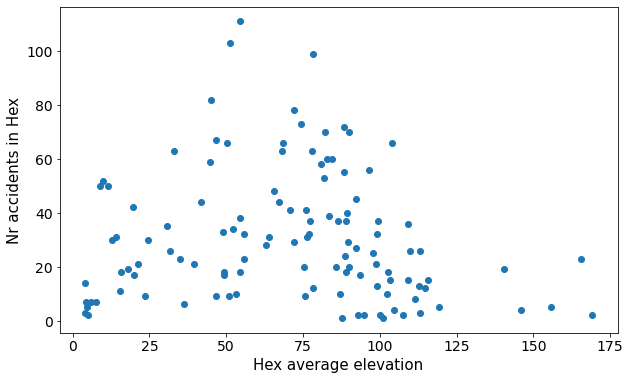

In [91]:
plt.figure(figsize=(10, 6))
axes = plt. gca()
axes.yaxis.label.set_size(15)
axes.xaxis.label.set_size(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(acidentes_altimetria['value_y'],acidentes_altimetria['value_x'])
#plt.plot(acidentes_altimetria['value_y'], m*acidentes_altimetria['value_y'] + b,'r-',linewidth=3)
plt.xlabel('Hex average elevation')
plt.ylabel('Nr accidents in Hex')

Spearmen test

In [21]:
stats.spearmanr(acidentes_altimetria['value_x'], acidentes_altimetria['value_y'])

SpearmanrResult(correlation=-0.1631315909284277, pvalue=0.08017108223418852)

Line plot

C:\Users\duartgo\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Nr accidents in Hex')

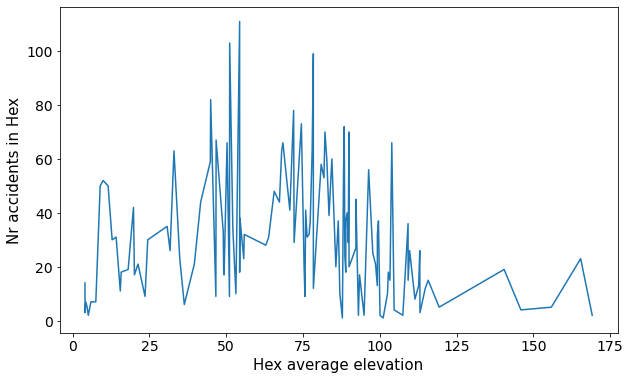

In [92]:
plt.figure(figsize=(10, 6))
axes = plt. gca()
axes.yaxis.label.set_size(15)
axes.xaxis.label.set_size(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.lineplot(acidentes_altimetria['value_y'],acidentes_altimetria['value_x'], data=acidentes_altimetria)
plt.xlabel('Hex average elevation')
plt.ylabel('Nr accidents in Hex')

As expected there isn't an appearent correlation between the elevation of a zone and the number of accidents that happen in said zone

# 2.2 Crossroads

Change data reference using crs

In [120]:
cruzamentos = gpd.read_file(path_cruzamentos)
cruzamentos_oldCRS=cruzamentos.crs
cruzamentos = cruzamentos.to_crs("EPSG:4326")
cruzamentos.T

,0,1,2,3,4,5,6,7,8,9,...,545,546,547,548,549,550,551,552,553,554
OBJECTID,1822,1823,1824,1825,1691,1714,1695,1713,1731,1763,...,1597,1598,1599,1601,1602,1603,1604,1605,1606,1607
SERIALID,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LOCAL,"Vasconcelos, R. Carolina Michaelis","Venezuela, R. da","Venezuela, R. da","Venezuela, R. da","Pacheco, Av. Eng. Duarte","Carlos I, Av. D.","Campolide, R. de","Carlos I, Av. D.","Ameixoeira, Est. da","Desvio, Est. do",...,"Henrique, Av. Infante D.","Henrique, Av. Infante D.","Tijolo, ChAv. do","Beato, R. do","Palha, R. Fernando","Palha, R. Fernando","Henrique, Av. Infante D.","Henrique, Av. Infante D.","Henrique, Av. Infante D.","Henrique, Av. Infante D."
LINK_DOC,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
OBS,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
DATAAVALIA,2019-02-14,2019-02-14,2019-02-14,2019-02-14,2019-02-08,2019-02-05,2019-02-12,2019-02-05,2019-02-21,2019-02-20,...,2019-02-20,2019-02-02,2019-02-02,2019-02-07,2019-02-07,2019-02-07,2019-02-07,2019-02-07,2019-02-16,2019-02-07
OPERADOR,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,...,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO
AREA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CODIGO_INT,671,541,721,547,585,299,557,319,573,471,...,050,260,645,654,688,647,649,648,686,687
CODIGO,671,541,721,547,585,299,557,319,573,471,...,050,260,645,654,688,647,649,648,686,687


Calculation of an crossroads indicator by reading each point within each geometry and converting it to an hex.

In [122]:
cruzamentos_h3pd=pd.DataFrame()
h3_shape=[]

for i in range(0,len(cruzamentos)):  
    if cruzamentos['geometry'][i] != None:
        if cruzamentos['geometry'][i].type=='Polygon':
            h3_shape.append(h3.geo_to_h3(cruzamentos['geometry'][i].centroid.coords[0][1],cruzamentos['geometry'][i].centroid.coords[0][0], resolution))
    
cruzamentos_h3pd['h3_hex']=h3_shape
cruzamentos_h3pd

,h3_hex
0,88393362c1fffff
1,88393362c1fffff
2,88393362c1fffff
3,88393362c1fffff
4,88393362b9fffff
...,...
550,8839336755fffff
551,8839336755fffff
552,8839336755fffff
553,883933675dfffff


Count number of crossroads in each hex

In [123]:
cruzamentos_h3pd=cruzamentos_h3pd.groupby(['h3_hex']).size().reset_index(name='counts')
cruzamentos_h3pd=pd.DataFrame(cruzamentos_h3pd)
cruzamentos_h3pd

,h3_hex,counts
0,8839336019fffff,3
1,8839336043fffff,3
2,8839336053fffff,2
3,8839336055fffff,3
4,8839336057fffff,1
...,...,...
87,88393375e3fffff,4
88,88393375e5fffff,4
89,88393375e7fffff,9
90,88393375e9fffff,2


Prepare map visualization

In [124]:
cruzamentos_h3pd=cruzamentos_h3pd.rename(columns={"h3_hex": "hex_id", "counts": "value"})
cruzamentos_h3pd["geometry"] =  cruzamentos_h3pd.hex_id.apply(lambda x: {"type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(x,geo_json=True)]})
cruzamentos_h3pd

,hex_id,value,geometry
0,8839336019fffff,3,"{'type': 'Polygon', 'coordinates': [((-9.19527..."
1,8839336043fffff,3,"{'type': 'Polygon', 'coordinates': [((-9.22822..."
2,8839336053fffff,2,"{'type': 'Polygon', 'coordinates': [((-9.20006..."
3,8839336055fffff,3,"{'type': 'Polygon', 'coordinates': [((-9.21724..."
4,8839336057fffff,1,"{'type': 'Polygon', 'coordinates': [((-9.20626..."
...,...,...,...
87,88393375e3fffff,4,"{'type': 'Polygon', 'coordinates': [((-9.14905..."
88,88393375e5fffff,4,"{'type': 'Polygon', 'coordinates': [((-9.16624..."
89,88393375e7fffff,9,"{'type': 'Polygon', 'coordinates': [((-9.15525..."
90,88393375e9fffff,2,"{'type': 'Polygon', 'coordinates': [((-9.16483..."


Create Map with number of crossroads per hex

In [125]:
hexmap = choropleth_map(df_aggreg = cruzamentos_h3pd, with_legend = True)
hexmap

In [126]:
acidentes_cruzamentos=pd.merge(df_aggreg,cruzamentos_h3pd ,on='hex_id')

Scatterplot of the number of accidents and crossroads for each hex with the linear fit

In [127]:
m, b = np.polyfit(acidentes_cruzamentos['value_y'], acidentes_cruzamentos['value_x'], 1)

Text(0, 0.5, 'Nr accidents in hex')

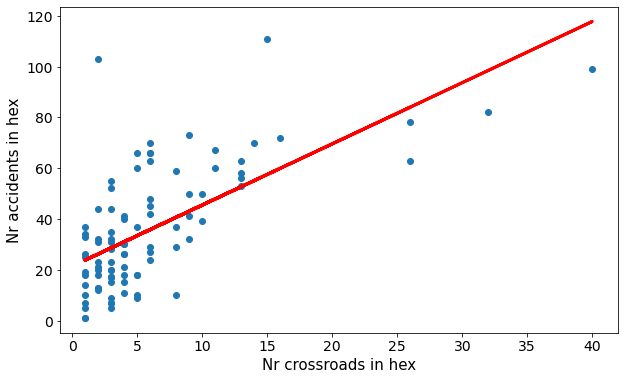

In [128]:
plt.figure(figsize=(10, 6))
axes = plt. gca()
axes.yaxis.label.set_size(15)
axes.xaxis.label.set_size(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(acidentes_cruzamentos['value_y'],acidentes_cruzamentos['value_x'])
plt.plot(acidentes_cruzamentos['value_y'], m*acidentes_cruzamentos['value_y'] + b,'r-',linewidth=3)
plt.xlabel('Nr crossroads in hex')
plt.ylabel('Nr accidents in hex')

Spearmen test

In [129]:
stats.spearmanr(acidentes_cruzamentos['value_x'], acidentes_cruzamentos['value_y'])

SpearmanrResult(correlation=0.6302887620121843, pvalue=1.670712457211837e-11)

Line plot

C:\Users\duartgo\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Nr accidents in hex')

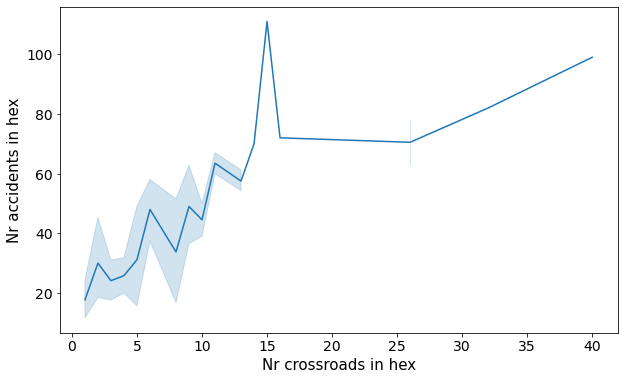

In [130]:
plt.figure(figsize=(10, 6))
axes = plt. gca()
axes.yaxis.label.set_size(15)
axes.xaxis.label.set_size(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.lineplot(acidentes_cruzamentos['value_y'],acidentes_cruzamentos['value_x'], data=acidentes_cruzamentos)
plt.xlabel('Nr crossroads in hex')
plt.ylabel('Nr accidents in hex')

There is a moderate positive correlation between the number of crossroads and the number of accidents in each hex.This positive correlation is somewhat expected due to the nature of crossroads which lead or accidents when road code is not respected. It should be noted that during the analysis of this specific dataset we noticed that many crossroads weren’t identified which could explain some apparent outliers in both plots and the data imbalance.

# 2.3 Slopes

Change data reference using crs

In [131]:
declives = gpd.read_file(path_declives)
declives_oldCrs = declives.crs
declives = declives.to_crs("EPSG:4326")
declives.T

,0,1,2,3,4,5,6,7,8,9,...,22088,22089,22090,22091,22092,22093,22094,22095,22096,22097
OBJECTID_1,1,2,3,4,5,6,7,8,9,10,...,22089,22090,22091,22092,22093,22094,22095,22096,22097,22098
OBJECTID,57475,57430,57431,57433,57434,57435,57436,57437,57438,57439,...,55739,55740,55741,55742,55743,55745,55744,55761,55762,0
COD_SIG,155181,155182,155183,155185,155186,155187,155188,155189,155190,155191,...,154379,154380,154381,154382,154383,154384,154385,154386,154387,None
IDTIPO,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,None
COD_VIA,67094,67144,67144,67144,67144,500000,67372,67333,101018,67333,...,66930,66745,66931,66941,66946,67321,462,462,462,None
DESIGNACAO,Largo de Dona EstefÃ¢nia,Estrada das Laranjeiras,Estrada das Laranjeiras,Estrada das Laranjeiras,Estrada das Laranjeiras,Rua Interior Particular,Rua Professor Lima Basto,Rua de Campolide,Via 1,Rua de Campolide,...,PraÃ§a Francisco SÃ¡ Carneiro,Avenida Almirante Gago Coutinho,Avenida Almirante Reis,Avenida Afonso Costa,PraÃ§a Bernardo Santareno,Rua do Parque,Avenida Infante Dom Henrique,Avenida Infante Dom Henrique,Avenida Infante Dom Henrique,PraÃ§a do ComÃ©rcio
ESTADO_VIA,Existente,Existente,Existente,Existente,Existente,Existente,Existente,Existente,Existente,Existente,...,Existente,Existente,Existente,Existente,Existente,Existente,Existente,Existente,Existente,None
DTM_ADD,2012-06-19,2012-06-19,2012-06-19,2012-06-19,2012-06-19,2012-06-19,2012-06-19,2012-06-19,2012-06-19,2012-06-19,...,2012-06-12,2012-06-12,2012-06-12,2012-06-12,2012-06-12,2012-06-12,2012-06-12,2012-06-12,2012-06-12,1899-12-30
DTM_UPD,2012-06-19,2012-06-19,2012-06-19,2012-06-19,2012-06-19,2012-06-19,2012-06-19,2012-06-19,2012-06-19,2012-06-19,...,2012-06-12,2012-06-12,2012-06-12,2012-06-12,2012-06-12,2012-06-12,2012-06-12,2012-06-12,2012-07-30,1899-12-30
COMPRIMENT,15.58,10.52,31.01,12.9,82.63,17.52,53.49,103.97,42.88,39.27,...,32.24,31.44,160.23,87.54,14.68,20.77,16.21,26.97,495.18,0.0


Calculation of a slope indicator by reading each point within each geometry and converting it to an hex.

In [133]:
declives_h3pd=pd.DataFrame()
h3_shape=[]
slope=[]


for i in range(0,len(declives)):  
    if declives['geometry'][i] != None:
        if declives['geometry'][i].type=='LineString':
            for j in range(0,len(declives['geometry'][i].coords)):
                h3_shape.append(h3.geo_to_h3(declives['geometry'][i].coords[j][1],declives['geometry'][i].coords[j][0], resolution))
                slope.append(declives.slope[i])
        elif declives['geometry'][i].type=='MultiLineString':
            for k in range(0,len(declives['geometry'][i])):
                for j in range(0,len(declives['geometry'][i][k].coords)):
                    h3_shape.append(h3.geo_to_h3(declives['geometry'][i][k].coords[j][1],declives['geometry'][i][k].coords[j][0], resolution))
                    slope.append(declives.slope[i])
    
declives_h3pd['h3_hex']=h3_shape
declives_h3pd['slope']=slope
declives_h3pd

,h3_hex,slope
0,8839336297fffff,0.385109
1,8839336297fffff,0.385109
2,8839336297fffff,0.385109
3,8839336297fffff,0.385109
4,8839336297fffff,0.385109
...,...,...
1717968,88393375bbfffff,1.548932
1717969,88393375bbfffff,1.548932
1717970,88393375bbfffff,1.548932
1717971,88393360d9fffff,0.000000


Slope elevation

In [134]:
declives_h3pd=declives_h3pd.groupby(['h3_hex'])['slope'].mean().reset_index()
declives_h3pd=pd.DataFrame(declives_h3pd)

Prepare map visualization

In [135]:
declives_h3pd=declives_h3pd.rename(columns={"h3_hex": "hex_id", "slope": "value"})
declives_h3pd["geometry"] =  declives_h3pd.hex_id.apply(lambda x: {"type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(x,geo_json=True)]})
declives_h3pd

,hex_id,value,geometry
0,8839336009fffff,0.549428,"{'type': 'Polygon', 'coordinates': [((-9.22343..."
1,8839336019fffff,0.987235,"{'type': 'Polygon', 'coordinates': [((-9.19527..."
2,883933601bfffff,0.084452,"{'type': 'Polygon', 'coordinates': [((-9.18429..."
3,8839336043fffff,0.898278,"{'type': 'Polygon', 'coordinates': [((-9.22822..."
4,8839336051fffff,4.233748,"{'type': 'Polygon', 'coordinates': [((-9.21104..."
...,...,...,...
125,88393375e5fffff,3.379726,"{'type': 'Polygon', 'coordinates': [((-9.16624..."
126,88393375e7fffff,3.220068,"{'type': 'Polygon', 'coordinates': [((-9.15525..."
127,88393375e9fffff,5.538543,"{'type': 'Polygon', 'coordinates': [((-9.16483..."
128,88393375ebfffff,4.855159,"{'type': 'Polygon', 'coordinates': [((-9.15384..."


Create Map with average slope per hex

In [136]:
hexmap = choropleth_map(df_aggreg = declives_h3pd, with_legend = True)
hexmap

In [169]:
acidentes_declives=pd.merge(df_aggreg,declives_h3pd ,on='hex_id')

Scatterplot of the number of accidents and slope for each hex

In [138]:
#m, b = np.polyfit(acidentes_declives['value_y'], acidentes_declives['value_x'], 1)

In [ ]:
plt.figure(figsize=(10, 6))
axes = plt. gca()
axes.yaxis.label.set_size(15)
axes.xaxis.label.set_size(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(acidentes_declives['value_y'],acidentes_declives['value_x'])
#plt.plot(acidentes_declives['value_y'], m*acidentes_declives['value_y'] + b,'r-',linewidth=3)
plt.xlabel('Hex average slope')
plt.ylabel('Nr accidents in hex')

Spearmen test

In [140]:
stats.spearmanr(acidentes_declives['value_x'], acidentes_declives['value_y'])

SpearmanrResult(correlation=0.09772788110878065, pvalue=0.2987788992445031)

Line plot

C:\Users\duartgo\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Nr accidents in hex')

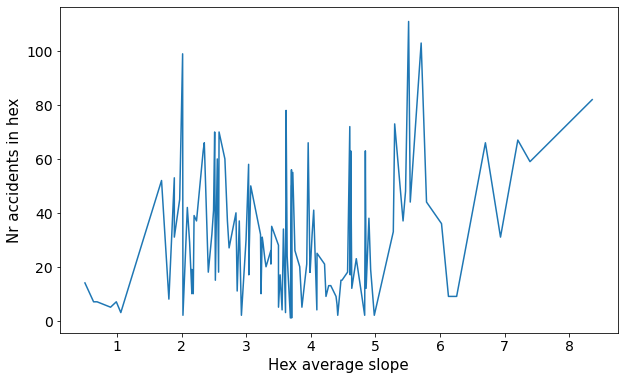

In [141]:
plt.figure(figsize=(10, 6))
axes = plt. gca()
axes.yaxis.label.set_size(15)
axes.xaxis.label.set_size(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.lineplot(acidentes_declives['value_y'],acidentes_declives['value_x'], data=acidentes_declives)
plt.xlabel('Hex average slope')
plt.ylabel('Nr accidents in hex')

As expected there isn't an appearent correlation between the slope of a zone and the number of accidents that happen in said zone. One could argue that a significant slope could interfere with the control of a car but maybe that is compensated by a more caution from the driver.

# 2.4. Traffic lights

Every step relative to traffic lights analysis was copied from the crossroad analysis considering that the datasets are similar.

In [142]:
semaforos = gpd.read_file(path_semaforos)
semaforos_oldCrs = semaforos.crs
semaforos = semaforos.to_crs("EPSG:4326")
semaforos.T

,0,1,2,3,4,5,6,7,8,9,...,545,546,547,548,549,550,551,552,553,554
OBJECTID,1822,1823,1824,1825,1691,1714,1695,1713,1731,1763,...,1597,1598,1599,1601,1602,1603,1604,1605,1606,1607
SERIALID,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LOCAL,"Vasconcelos, R. Carolina Michaelis","Venezuela, R. da","Venezuela, R. da","Venezuela, R. da","Pacheco, Av. Eng. Duarte","Carlos I, Av. D.","Campolide, R. de","Carlos I, Av. D.","Ameixoeira, Est. da","Desvio, Est. do",...,"Henrique, Av. Infante D.","Henrique, Av. Infante D.","Tijolo, ChAv. do","Beato, R. do","Palha, R. Fernando","Palha, R. Fernando","Henrique, Av. Infante D.","Henrique, Av. Infante D.","Henrique, Av. Infante D.","Henrique, Av. Infante D."
LINK_DOC,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
OBS,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
DATAAVALIA,2019-02-14,2019-02-14,2019-02-14,2019-02-14,2019-02-08,2019-02-05,2019-02-12,2019-02-05,2019-02-21,2019-02-20,...,2019-02-20,2019-02-02,2019-02-02,2019-02-07,2019-02-07,2019-02-07,2019-02-07,2019-02-07,2019-02-16,2019-02-07
OPERADOR,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,...,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO,ENGIDRO
AREA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CODIGO_INT,671,541,721,547,585,299,557,319,573,471,...,050,260,645,654,688,647,649,648,686,687
CODIGO,671,541,721,547,585,299,557,319,573,471,...,050,260,645,654,688,647,649,648,686,687


In [144]:
semaforos_h3pd=pd.DataFrame()
h3_shape=[]

for i in range(0,len(semaforos)):  
    if semaforos['geometry'][i] != None:
        if semaforos['geometry'][i].type=='Polygon':
            h3_shape.append(h3.geo_to_h3(semaforos['geometry'][i].centroid.coords[0][1],semaforos['geometry'][i].centroid.coords[0][0], resolution))
    
semaforos_h3pd['h3_hex']=h3_shape
semaforos_h3pd

,h3_hex
0,88393362c1fffff
1,88393362c1fffff
2,88393362c1fffff
3,88393362c1fffff
4,88393362b9fffff
...,...
550,8839336755fffff
551,8839336755fffff
552,8839336755fffff
553,883933675dfffff


In [145]:
semaforos_h3pd=semaforos_h3pd.groupby(['h3_hex']).size().reset_index(name='counts')
semaforos_h3pd=pd.DataFrame(semaforos_h3pd)
semaforos_h3pd

,h3_hex,counts
0,8839336019fffff,3
1,8839336043fffff,3
2,8839336053fffff,2
3,8839336055fffff,3
4,8839336057fffff,1
...,...,...
87,88393375e3fffff,4
88,88393375e5fffff,4
89,88393375e7fffff,9
90,88393375e9fffff,2


In [146]:
semaforos_h3pd=semaforos_h3pd.rename(columns={"h3_hex": "hex_id", "counts": "value"})
semaforos_h3pd["geometry"] =  semaforos_h3pd.hex_id.apply(lambda x: {"type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(x,geo_json=True)]})
semaforos_h3pd

,hex_id,value,geometry
0,8839336019fffff,3,"{'type': 'Polygon', 'coordinates': [((-9.19527..."
1,8839336043fffff,3,"{'type': 'Polygon', 'coordinates': [((-9.22822..."
2,8839336053fffff,2,"{'type': 'Polygon', 'coordinates': [((-9.20006..."
3,8839336055fffff,3,"{'type': 'Polygon', 'coordinates': [((-9.21724..."
4,8839336057fffff,1,"{'type': 'Polygon', 'coordinates': [((-9.20626..."
...,...,...,...
87,88393375e3fffff,4,"{'type': 'Polygon', 'coordinates': [((-9.14905..."
88,88393375e5fffff,4,"{'type': 'Polygon', 'coordinates': [((-9.16624..."
89,88393375e7fffff,9,"{'type': 'Polygon', 'coordinates': [((-9.15525..."
90,88393375e9fffff,2,"{'type': 'Polygon', 'coordinates': [((-9.16483..."


In [147]:
hexmap = choropleth_map(df_aggreg = semaforos_h3pd, with_legend = True)
hexmap

In [148]:
acidentes_semaforos=pd.merge(df_aggreg,semaforos_h3pd ,on='hex_id')

In [149]:
m, b = np.polyfit(acidentes_semaforos['value_y'], acidentes_semaforos['value_x'], 1)

Text(0, 0.5, 'Nr accidents in hex')

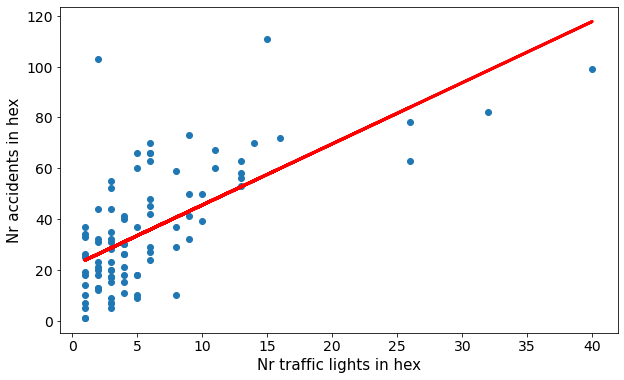

In [150]:
plt.figure(figsize=(10, 6))
axes = plt. gca()
axes.yaxis.label.set_size(15)
axes.xaxis.label.set_size(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(acidentes_semaforos['value_y'],acidentes_semaforos['value_x'])
plt.plot(acidentes_semaforos['value_y'], m*acidentes_semaforos['value_y'] + b,'r-',linewidth=3)
plt.xlabel('Nr traffic lights in hex')
plt.ylabel('Nr accidents in hex')

In [151]:
stats.spearmanr(acidentes_semaforos['value_x'], acidentes_semaforos['value_y'])

SpearmanrResult(correlation=0.6302887620121843, pvalue=1.670712457211837e-11)

C:\Users\duartgo\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Nr accidents in hex')

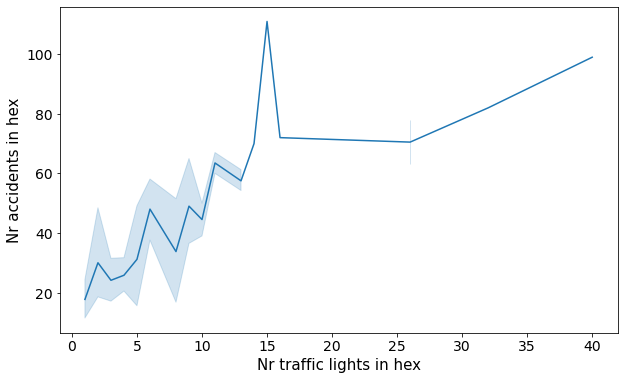

In [152]:
plt.figure(figsize=(10, 6))
axes = plt. gca()
axes.yaxis.label.set_size(15)
axes.xaxis.label.set_size(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.lineplot(acidentes_semaforos['value_y'],acidentes_semaforos['value_x'], data=acidentes_semaforos)
plt.xlabel('Nr traffic lights in hex')
plt.ylabel('Nr accidents in hex')

# 2.5. Traffic delay

Read data

In [153]:
path_traffic = '../00-data/processed/Acidentes_vs_transito.csv'
traffic = gpd.read_file(path_traffic)
traffic['Closest_DelayTraffic-10min'] = pd.to_numeric(traffic['Closest_DelayTraffic-10min'])
traffic

,field_1,level_0,index,data,latitude,longitude,tipo acidente,H3_point,data-10min,data+20min,Closest_Time-10min,Closest_DelayTraffic-10min,Closest_Time+20min,Closest_DelayTraffic+20min,geometry
0,0,0,0,2019-01-02 09:50:00,38.7209116,-9.1302425,ColisÃ£o/Despiste,8839336761fffff,2019-01-02 09:40:00,2019-01-02 10:10:00,2019-01-02 09:11:00,105.000000,2019-01-02 09:11:00,0.0,None
1,1,1,1,2019-01-02 12:25:00,38.738775,-9.157884,ColisÃ£o/Despiste,883933629dfffff,2019-01-02 12:15:00,2019-01-02 12:45:00,2019-01-02 13:07:00,0.000000,2019-01-02 13:07:00,133.0,None
2,2,2,2,2019-01-02 13:05:00,38.7287793,-9.1475178,ColisÃ£o/Despiste,8839336297fffff,2019-01-02 12:55:00,2019-01-02 13:25:00,2019-01-02 12:53:00,0.000000,2019-01-02 13:28:00,0.0,None
3,3,3,3,2019-01-02 15:10:00,38.7683668999999,-9.1728989,Atropelamento,8839337533fffff,2019-01-02 15:00:00,2019-01-02 15:30:00,2019-01-02 11:27:00,0.000000,2019-01-02 11:27:00,0.0,None
4,4,4,4,2019-01-02 15:30:00,38.7057907,-9.2052676,Atropelamento,883933605bfffff,2019-01-02 15:20:00,2019-01-02 15:50:00,2019-01-02 15:23:00,84.000000,2019-01-02 15:28:00,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3603,3603,3615,1792,2019-12-30 13:24:00,38.7549028909113,-9.17139828751204,ColisÃ£o/Despiste,88393362d1fffff,2019-12-30 13:14:00,2019-12-30 13:44:00,2019-12-30 13:12:00,92.000000,2019-12-30 13:22:00,0.0,None
3604,3604,3616,1793,2019-12-30 16:44:00,38.7289113695114,-9.16119034205223,ColisÃ£o/Despiste,8839336283fffff,2019-12-30 16:34:00,2019-12-30 17:04:00,2019-12-30 16:33:00,371.333333,2019-12-30 17:03:00,278.2,None
3605,3605,3617,1794,2019-12-30 19:51:00,38.7102378412857,-9.15339218543993,ColisÃ£o/Despiste,88393362b1fffff,2019-12-30 19:41:00,2019-12-30 20:11:00,2019-12-30 19:13:00,99.000000,2019-12-30 19:13:00,0.0,None
3606,3606,3618,1795,2019-12-31 15:19:00,38.7487126518545,-9.11873446256463,ColisÃ£o/Despiste,883933674bfffff,2019-12-31 15:09:00,2019-12-31 15:39:00,2019-12-31 15:05:00,143.000000,2019-12-31 15:44:00,108.0,None


Calculation of an average traffic delay for each hex and preparation for map creation.

In [154]:
traffic=traffic.groupby("H3_point")['Closest_DelayTraffic-10min'].mean().reset_index()
traffic=pd.DataFrame(traffic)
traffic=traffic.rename(columns={"H3_point": "hex_id", "Closest_DelayTraffic-10min": "value"})
traffic["geometry"] =  traffic.hex_id.apply(lambda x: {"type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(x,geo_json=True)]})
traffic

,hex_id,value,geometry
0,8839336013fffff,0.000000,"{'type': 'Polygon', 'coordinates': [((-9.17951..."
1,8839336019fffff,64.000000,"{'type': 'Polygon', 'coordinates': [((-9.19527..."
2,8839336043fffff,39.400000,"{'type': 'Polygon', 'coordinates': [((-9.22822..."
3,8839336051fffff,30.222222,"{'type': 'Polygon', 'coordinates': [((-9.21104..."
4,8839336053fffff,24.065217,"{'type': 'Polygon', 'coordinates': [((-9.20006..."
...,...,...,...
114,88393375e5fffff,57.202564,"{'type': 'Polygon', 'coordinates': [((-9.16624..."
115,88393375e7fffff,53.125000,"{'type': 'Polygon', 'coordinates': [((-9.15525..."
116,88393375e9fffff,38.227273,"{'type': 'Polygon', 'coordinates': [((-9.16483..."
117,88393375ebfffff,23.541667,"{'type': 'Polygon', 'coordinates': [((-9.15384..."


Create Map with average traffic delay per hex

In [155]:
hexmap = choropleth_map(df_aggreg = traffic, with_legend = True)
hexmap

In [156]:
acidentes_traffic=pd.merge(df_aggreg,traffic ,on='hex_id')
acidentes_traffic

,hex_id,value_x,geometry_x,value_y,geometry_y
0,88393362bbfffff,111,"{'type': 'Polygon', 'coordinates': [((-9.14852...",127.783705,"{'type': 'Polygon', 'coordinates': [((-9.14852..."
1,8839336287fffff,103,"{'type': 'Polygon', 'coordinates': [((-9.17049...",96.521706,"{'type': 'Polygon', 'coordinates': [((-9.17049..."
2,8839336291fffff,99,"{'type': 'Polygon', 'coordinates': [((-9.14710...",67.937455,"{'type': 'Polygon', 'coordinates': [((-9.14710..."
3,8839336765fffff,82,"{'type': 'Polygon', 'coordinates': [((-9.13276...",49.135163,"{'type': 'Polygon', 'coordinates': [((-9.13276..."
4,8839336293fffff,78,"{'type': 'Polygon', 'coordinates': [((-9.13612...",110.503632,"{'type': 'Polygon', 'coordinates': [((-9.13612..."
...,...,...,...,...,...
114,8839337593fffff,2,"{'type': 'Polygon', 'coordinates': [((-9.09269...",62.000000,"{'type': 'Polygon', 'coordinates': [((-9.09269..."
115,883933753dfffff,2,"{'type': 'Polygon', 'coordinates': [((-9.19922...",247.750000,"{'type': 'Polygon', 'coordinates': [((-9.19922..."
116,8839337527fffff,2,"{'type': 'Polygon', 'coordinates': [((-9.21162...",79.000000,"{'type': 'Polygon', 'coordinates': [((-9.21162..."
117,8839337531fffff,1,"{'type': 'Polygon', 'coordinates': [((-9.18822...",0.000000,"{'type': 'Polygon', 'coordinates': [((-9.18822..."


Scatterplot of the number of accidents and traffic delay for each hex with best linear fit

In [157]:
m, b = np.polyfit(acidentes_traffic['value_y'], acidentes_traffic['value_x'], 1)

Text(0, 0.5, 'Nr accidents in Hex')

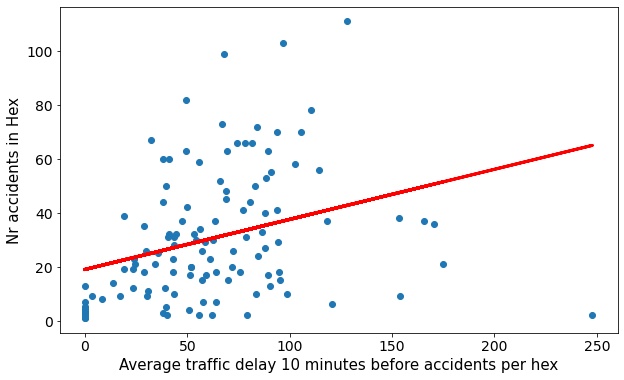

In [158]:
plt.figure(figsize=(10, 6))
axes = plt. gca()
axes.yaxis.label.set_size(15)
axes.xaxis.label.set_size(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(acidentes_traffic['value_y'],acidentes_traffic['value_x'])
plt.plot(acidentes_traffic['value_y'], m*acidentes_traffic['value_y'] + b,'r-',linewidth=3)
plt.xlabel('Average traffic delay 10 minutes before accidents per hex')
plt.ylabel('Nr accidents in Hex')

Spearmen test

In [159]:
stats.spearmanr(acidentes_traffic['value_x'], acidentes_traffic['value_y'])

SpearmanrResult(correlation=0.4334511795870109, pvalue=8.476092219911178e-07)

Line plot

C:\Users\duartgo\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Nr accidents in Hex')

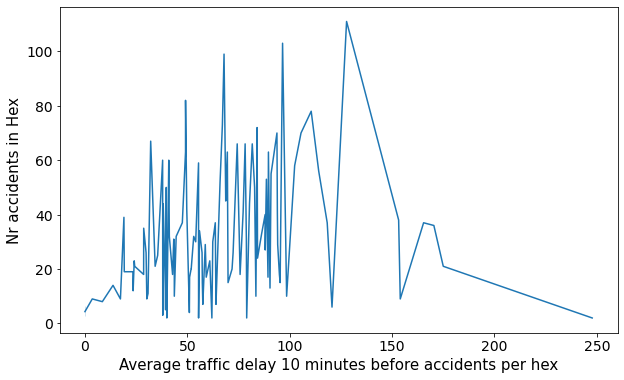

In [160]:
plt.figure(figsize=(10, 6))
axes = plt. gca()
axes.yaxis.label.set_size(15)
axes.xaxis.label.set_size(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.lineplot(acidentes_traffic['value_y'],acidentes_traffic['value_x'], data=acidentes_traffic)
plt.xlabel('Average traffic delay 10 minutes before accidents per hex')
plt.ylabel('Nr accidents in Hex')

Even though we obtained with the spearman test a coefficient of 0.43 with a p-value of 8.48x10-7, due to the dispersion of results in the scatter plot and the absence of a defined pattern we considered a inexistence of  correlation between these two variables. This result is unexpected because one could think that with the increase of traffic it would be more likely to happen an accident due to the proximity associated with traffic. Maybe this is why a very weak correlation is present but nonetheless we don’t consider it a relevant one according to the results.